In [1]:
from torch.utils.data import Dataset
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch import nn
import torch
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from sklearn import decomposition
import seaborn as sns
from random import randint
from augment_functions import random_mask, resize_encoder
import torch.nn.functional as F
from torchmetrics.image import StructuralSimilarityIndexMeasure, PeakSignalNoiseRatio
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from downstream_model_lstm_no_decoder.downstream_task_main import downstream_task as downstream_task_lstm_no_decoder

In [2]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)

In [3]:
def resize_encoder(sample):
    sample = F.interpolate(sample, size=(144, 72), mode='bicubic', align_corners=False)
    return sample

class WeatherBenchDatasetWindow(Dataset):
    def __init__(self, data, context_length, target_length, stride=1):
        self.data = data
        self.context_length = context_length
        self.target_length = target_length
        self.stride = stride
        
    def __len__(self):
        return (self.data.shape[0] - (self.context_length + self.target_length)) // self.stride + 1

    def __getitem__(self, idx):
        x = random_mask(resize_encoder(self.data[idx:idx + self.context_length]))
        y = self.data[idx + self.context_length:idx + self.context_length + self.target_length]
        y_masked = random_mask(resize_encoder(y))
        return x, y_masked, y

In [4]:
seq2seq_model = torch.load('downstream_model_no_decoder.pth', weights_only=False, map_location=DEVICE)
model = torch.load('det_autoencoder.pth', weights_only=False, map_location=DEVICE)
model.eval()
seq2seq_model.eval()

encoder_model = model.encoder
decoder_model = model.decoder

data = torch.load('/vol/bitbucket/nb324/ERA5_64x32_daily_850.pt')
n_samples = data.shape[0]
n_train = int(n_samples * 0.6)
n_valid = int(n_samples * 0.2)
data = data[n_train+n_valid:]


BATCH_SIZE = 1
n_samples = data.shape[0]

n_train = int(n_samples * 0.6)
n_valid = int(n_samples * 0.2)

train_data = data[:n_train]
valid_data = data[n_train:n_train+n_valid]
test_data = data[n_train+n_valid:]

mean = train_data.mean(dim=(0, 2, 3), keepdim=True)
std = train_data.std(dim=(0, 2, 3), keepdim=True)

test_data = (test_data - mean) / std

test_dataset = WeatherBenchDatasetWindow(data=test_data, context_length=30, target_length=1, stride=1)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [5]:
# Grab a batch
batch = list(testloader)[0]

input_data = batch[0].to(DEVICE)
output_data_masked = batch[1].to(DEVICE)
output_data = batch[2].to(DEVICE)

print(input_data.shape)
print(output_data_masked.shape)
print(output_data.shape)

torch.Size([1, 30, 5, 144, 72])
torch.Size([1, 1, 5, 144, 72])
torch.Size([1, 1, 5, 64, 32])


In [6]:
def prepare_inputs(input_data, output_data, encoder_model):
    B, T, C, H, W = input_data.shape
    input_data = input_data.reshape(B*T, C, H, W)
    input_encoded_data, _ = encoder_model(input_data)

    input_encoded_data = input_encoded_data.reshape(B, T, -1)
    B, T, C, H, W = output_data.shape
    output_data = output_data.reshape(B*T, C, H, W)

    output_encoded_data = encoder_model(output_data)[0]
    output_encoded_data = output_encoded_data.reshape(B, T, -1)
    return input_encoded_data, output_encoded_data

In [7]:
with torch.no_grad():
    input_encoded_data, output_encoded_data = prepare_inputs(input_data, output_data_masked, encoder_model)
    model_pred = seq2seq_model(input_encoded_data)
    if model_pred.ndim == 2:
        model_pred = model_pred.unsqueeze(0)
    B, T, L = model_pred.shape
    model_pred = model_pred.reshape(B*T, L)
    output_encoded_data = output_encoded_data.reshape(B*T, L)
    decoded_data = decoder_model(model_pred)
    B, T, C, H, W = output_data.shape
    output_data = output_data.reshape(B*T, C, H, W)
    B, T, C, H, W = output_data_masked.shape
    output_data_masked = output_data_masked.reshape(B*T, C, H, W)
    # _, C, H, W = decoded_data.shape
    # decoded_data = decoded_data.reshape(B, T, C, H, W)

In [8]:
output_data = output_data[0].unsqueeze(0)
output_data_masked = output_data_masked[0].unsqueeze(0)
decoded_data = decoded_data[0].unsqueeze(0)

In [9]:
mse_loss = torch.nn.MSELoss()
ssim_loss = StructuralSimilarityIndexMeasure(data_range=None)
psnr_loss = PeakSignalNoiseRatio(data_range=None)

mse = mse_loss(decoded_data, output_data)
ssim = ssim_loss(decoded_data, output_data)
psnr = psnr_loss(decoded_data, output_data)

print(f"Masked MSE Loss: {mse:.4f}")
print(f"Masked SSIM Loss: {ssim:.4f}")
print(f"Masked PSNR Loss: {psnr:.4f}")


ssim_loss = StructuralSimilarityIndexMeasure(data_range=1.0)
psnr_loss = PeakSignalNoiseRatio(data_range=1.0)
decoded_data_ = decoded_data * std + mean
output_data_ = output_data * std + mean

x_min = train_data.amin(dim=(0, 2, 3), keepdim=True)
x_max = train_data.amax(dim=(0, 2, 3), keepdim=True)

decoded_data_ = (decoded_data_ - x_min) / (x_max - x_min + 1e-8)
output_data_ = (output_data_ - x_min) / (x_max - x_min + 1e-8)

ssim = ssim_loss(decoded_data_, output_data_)
psnr = psnr_loss(decoded_data_, output_data_)

print(f"Masked Normalised SSIM Loss: {ssim:.4f}")
print(f"Masked Normalised PSNR Loss: {psnr:.4f}")

Masked MSE Loss: 0.9518
Masked SSIM Loss: 0.2146
Masked PSNR Loss: 18.2197
Masked Normalised SSIM Loss: 0.3808
Masked Normalised PSNR Loss: 17.2802


In [10]:
x_temp = output_data[:, 0, :, :].unsqueeze(1).squeeze(0).permute(1,2,0).cpu().numpy()

masked_x_temp = output_data_masked[:, 0, :, :].unsqueeze(1).squeeze(0).permute(1,2,0).cpu().numpy()
recon_masked_x_temp = decoded_data[:, 0, :, :].unsqueeze(1).squeeze(0).permute(1,2,0).cpu().numpy()



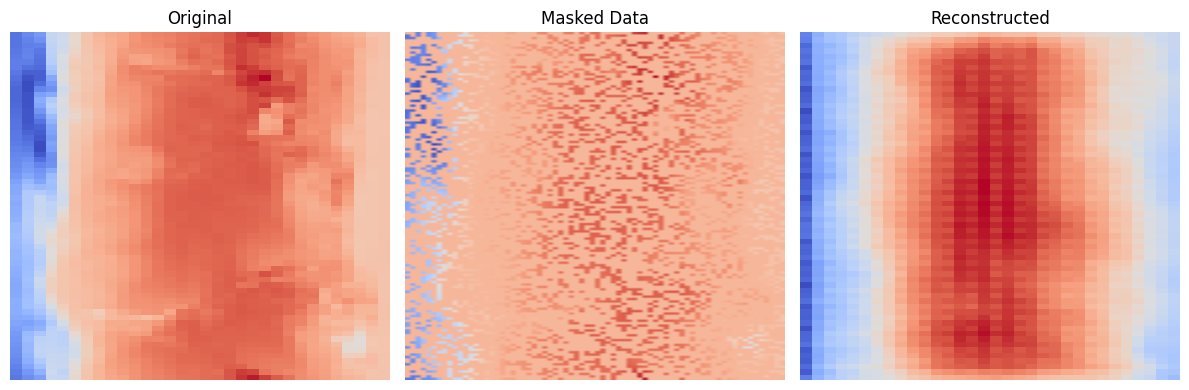

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(x_temp, cmap='coolwarm', aspect='auto')
axs[0].set_title('Original')
axs[0].axis('off')

axs[1].imshow(masked_x_temp, cmap='coolwarm', aspect='auto')
axs[1].set_title('Masked Data')
axs[1].axis('off')

axs[2].imshow(recon_masked_x_temp, cmap='coolwarm', aspect='auto')
axs[2].set_title('Reconstructed')
axs[2].axis('off')

plt.tight_layout()
plt.show()